# Connect to google account

In [410]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [411]:
!pip install category_encoders

In [412]:
# 모듈 Import
import random
import numpy as np # 행렬 계산에 사용하는 모듈
import pandas as pd # 데이터 처리와 분석을 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화를 위한 모듈. 2D, 3D 그릴 때 사용
import seaborn as sns # 데이터 시각화를 위한 모듈. 두 데이터의 관계를 볼때 사용

import category_encoders as ce

from datetime import datetime, timedelta
from tqdm.auto import tqdm

In [413]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/플레이데이터 데이터엔지니어링 28기/Dacon/KMU/data/" # 메인 경로
args.apply_train_path = args.default_path + "apply_train.csv" # train 데이터 경로
args.company_path = args.default_path + "company.csv"
args.recruitment_path = args.default_path + "recruitment.csv"
args.resume_certificate_path = args.default_path + "resume_certificate.csv"
args.resume_education_path = args.default_path + "resume_education.csv"
args.resume_language_path = args.default_path + "resume_language.csv"
args.resume_path = args.default_path + "resume.csv"

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [414]:
args.submission_path = args.default_path + "result/submission_20231108.csv" # 결과 저장 파일
args.save_results = args.default_path+"result/model_results_20231108.json" # 결과 저장 json

In [415]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    #recall = np.mean(individual_recalls)
    recall = max(individual_recalls)
    return recall

# File Load

In [416]:
apply_train_df = pd.read_csv(args.apply_train_path) # apply_train -> DataFrame화
company_df = pd.read_csv(args.company_path) # company -> DataFrame화
recruitment_df = pd.read_csv(args.recruitment_path) # recruitment -> DataFrame화
resume_certificate_df = pd.read_csv(args.resume_certificate_path) # resume_certificate -> DataFreame화
resume_education_df = pd.read_csv(args.resume_education_path) # resume_education -> DataFrame화
resume_language_df = pd.read_csv(args.resume_language_path) # resume_language -> DataFrame화
resume_df = pd.read_csv(args.resume_path) # resume -> DataFrame화
submission_df = pd.read_csv(args.default_submission_path)

In [417]:
apply_train = apply_train_df.copy()
company = company_df.copy()
recruitment = recruitment_df.copy()
resume_certificate = resume_certificate_df.copy()
resume_education = resume_education_df.copy()
resume_language = resume_language_df.copy()
resume = resume_df.copy()


# 탐색

### merged_recruitment 생성

In [418]:
# recruitment, company 정렬(recruitment_seq 기준)
company = company.sort_values(by = "recruitment_seq")
recruitment = recruitment.sort_values(by = "recruitment_seq")

In [419]:
# merged_recruitment = recruitment, company merge
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


### merged_recruitment 탐색 & drop

In [420]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   address_seq2       100 non-null    float64
 3   address_seq3       9 non-null      float64
 4   career_end         6695 non-null   int64  
 5   career_start       6695 non-null   int64  
 6   check_box_keyword  6695 non-null   object 
 7   education          6695 non-null   int64  
 8   major_task         6695 non-null   int64  
 9   qualifications     6695 non-null   int64  
 10  text_keyword       707 non-null    object 
 11  company_type_seq   2377 non-null   float64
 12  supply_kind        2377 non-null   float64
 13  employee           2377 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 784.6+ KB


In [421]:
merged_recruitment.describe()

,address_seq1,address_seq2,address_seq3,career_end,career_start,education,major_task,qualifications,company_type_seq,supply_kind,employee
count,6694.000000,100.000000,9.000000,6695.0,6695.0,6695.000000,6695.000000,6695.000000,2377.000000,2377.000000,2377.000000
mean,3.103675,7.900000,16.555556,0.0,0.0,3.081703,2.277521,1.317401,2.944468,344.090029,217.696676
std,0.955459,7.399836,6.424778,0.0,0.0,0.753074,1.242267,0.477852,1.739406,131.232212,331.153073
min,1.000000,1.000000,3.000000,0.0,0.0,2.000000,1.000000,0.000000,2.000000,100.000000,0.000000
25%,3.000000,1.000000,18.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,41.000000
50%,3.000000,5.000000,20.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,145.000000
75%,3.000000,14.000000,20.000000,0.0,0.0,4.000000,2.000000,2.000000,4.000000,402.000000,300.000000
max,20.000000,20.000000,20.000000,0.0,0.0,6.000000,10.000000,2.000000,9.000000,605.000000,12223.000000


In [422]:
(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.000000
career_end           0.000000
career_start         0.000000
check_box_keyword    0.000000
education            0.000000
major_task           0.000000
qualifications       0.000000
address_seq1         0.000149
company_type_seq     0.644959
supply_kind          0.644959
employee             0.644959
text_keyword         0.894399
address_seq2         0.985063
address_seq3         0.998656
dtype: float64

- 결측치가 90프로 이상인 컬럼 2개 존재
  - address_seq2, address_seq3 : drop 해도 괜찮을 것 같다.
- text_keyword(모집직무키워드) : 키워드 정리할 수 있는 방법
- employee(종업원수), supply_kind(주업종코드), company_type_seq(회사유형코드) : 동일한 index의 값이 결측치다. 분포도를 확인하여 채울 것인지 drop 할건지 결정
- address_seq1(근무지주소) : mode로 해도 될듯하다.

[other col]
- career_start, career_end : 값이 다 없는 상황이기에 drop 해도 괜찮을 것 같다.
- education : 요구학위와 resume의 최종학력과의 관계?
- company_type_seq : 중소, 중견, 대기업 구분?

In [423]:
merged_recruitment_drop_col = ['address_seq2','address_seq3', 'career_start', 'career_end', 'text_keyword']
merged_recruitment = merged_recruitment.drop(merged_recruitment_drop_col, axis=1)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   company_type_seq   2377 non-null   float64
 7   supply_kind        2377 non-null   float64
 8   employee           2377 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 523.0+ KB


 - check_box_keyword

In [424]:
for i in range(len(merged_recruitment)):
    lst=merged_recruitment['check_box_keyword'].iloc[i].split(';')
    for keyword in lst:
        if 'check_box_'+keyword not in merged_recruitment:
            merged_recruitment['check_box_'+keyword] = 0
        merged_recruitment['check_box_'+keyword][i]=1
drop_cols=[]
start_idx= merged_recruitment.columns.get_loc('check_box_2507')
for i in range (start_idx,merged_recruitment.shape[1]):
    count_of_ones = (merged_recruitment.iloc[:,i] == 1).sum()
    # 1의 갯수가 100개 이하이면 drop함 현재 20개 컬럼이 생기는데, 400으로하면 10개만생김
    if count_of_ones < 100:
        drop_cols.append(merged_recruitment.columns[i])

merged_recruitment.drop(drop_cols,axis =1 , inplace=True)

<ipython-input-424-af4f856c71ed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_recruitment['check_box_'+keyword][i]=1
<ipython-input-424-af4f856c71ed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_recruitment['check_box_'+keyword][i]=1
<ipython-input-424-af4f856c71ed>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_recruitment['check_box_'+keyword][i]=1
<ipython-input-424-af4f856c71ed>:6: SettingWithCopyWarn

In [425]:
# ';'을 기준으로 데이터 분할 및 단어 수 카운트 함수
def count_keywords(row):
    keywords = row['check_box_keyword'].split(';')
    return len(keywords)

# 'check_box_keyword' 컬럼의 데이터를 ';'을 기준으로 분할하고 단어 수를 새로운 컬럼에 저장
merged_recruitment['check_box_keyword_cnt'] = merged_recruitment.apply(count_keywords, axis=1)


In [426]:
merged_recruitment.drop(columns = 'check_box_keyword_cnt', inplace = True)

In [427]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   company_type_seq   2377 non-null   float64
 7   supply_kind        2377 non-null   float64
 8   employee           2377 non-null   float64
 9   check_box_2101     6695 non-null   int64  
 10  check_box_2108     6695 non-null   int64  
 11  check_box_2201     6695 non-null   int64  
 12  check_box_2204     6695 non-null   int64  
 13  check_box_2205     6695 non-null   int64  
 14  check_box_2707     6695 non-null   int64  
 15  check_box_2810     6695 non-null   int64  
 16  check_box_2507     6695 

In [428]:
# check_box_keyword_1 피처 생성
merged_recruitment['check_box_keyword_1']=merged_recruitment['check_box_keyword'].str.split(';').str[0]
merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,company_type_seq,supply_kind,employee,check_box_2101,...,check_box_2203,check_box_2501,check_box_2104,check_box_2105,check_box_3008,check_box_3099,check_box_2302,check_box_2299,check_box_2102,check_box_keyword_1
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,5.0,201.0,631.0,1,...,0,0,0,0,0,0,0,0,0,2101
1,R00002,3.0,2507;2703;2707,3,2,1,2.0,201.0,160.0,0,...,0,0,0,0,0,0,0,0,0,2507
2,R00003,3.0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,0,2101
3,R00004,3.0,2507;2707,3,2,1,2.0,402.0,500.0,0,...,0,0,0,0,0,0,0,0,0,2507
4,R00005,3.0,2507;2707,3,2,1,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,2507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,NaN,NaN,NaN,0,...,0,1,0,0,0,0,0,0,0,2501
6691,R06692,3.0,2201;2507,3,2,2,4.0,402.0,150.0,0,...,0,0,0,0,0,0,0,0,0,2201
6692,R06693,5.0,2102;2707,4,2,1,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,1,2102
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,1,...,1,0,0,0,0,0,0,0,0,2101


In [429]:
# check_box_keyword_1을 '직무'로 카테고리화
merged_recruitment['recruit_code'] = ''
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2101', 'recruit_code'] = 'MD'
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2507', 'recruit_code'] = '디자이너'
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2201', 'recruit_code'] = '영업 및 관리'
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2204', 'recruit_code'] = 'VMD'
merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,company_type_seq,supply_kind,employee,check_box_2101,...,check_box_2501,check_box_2104,check_box_2105,check_box_3008,check_box_3099,check_box_2302,check_box_2299,check_box_2102,check_box_keyword_1,recruit_code
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,5.0,201.0,631.0,1,...,0,0,0,0,0,0,0,0,2101,MD
1,R00002,3.0,2507;2703;2707,3,2,1,2.0,201.0,160.0,0,...,0,0,0,0,0,0,0,0,2507,디자이너
2,R00003,3.0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,2101,MD
3,R00004,3.0,2507;2707,3,2,1,2.0,402.0,500.0,0,...,0,0,0,0,0,0,0,0,2507,디자이너
4,R00005,3.0,2507;2707,3,2,1,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,2507,디자이너
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,NaN,NaN,NaN,0,...,1,0,0,0,0,0,0,0,2501,
6691,R06692,3.0,2201;2507,3,2,2,4.0,402.0,150.0,0,...,0,0,0,0,0,0,0,0,2201,영업 및 관리
6692,R06693,5.0,2102;2707,4,2,1,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,1,2102,
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,2101,MD


In [430]:
# '기타' 추가
merged_recruitment['recruit_code'] = merged_recruitment['check_box_keyword_1'].map({
    '2101': 'MD',
    '2507': '디자이너',
    '2201': '영업 및 관리',
    '2204': 'VMD'
}).fillna('기타')

merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,company_type_seq,supply_kind,employee,check_box_2101,...,check_box_2501,check_box_2104,check_box_2105,check_box_3008,check_box_3099,check_box_2302,check_box_2299,check_box_2102,check_box_keyword_1,recruit_code
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,5.0,201.0,631.0,1,...,0,0,0,0,0,0,0,0,2101,MD
1,R00002,3.0,2507;2703;2707,3,2,1,2.0,201.0,160.0,0,...,0,0,0,0,0,0,0,0,2507,디자이너
2,R00003,3.0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,2101,MD
3,R00004,3.0,2507;2707,3,2,1,2.0,402.0,500.0,0,...,0,0,0,0,0,0,0,0,2507,디자이너
4,R00005,3.0,2507;2707,3,2,1,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,2507,디자이너
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,NaN,NaN,NaN,0,...,1,0,0,0,0,0,0,0,2501,기타
6691,R06692,3.0,2201;2507,3,2,2,4.0,402.0,150.0,0,...,0,0,0,0,0,0,0,0,2201,영업 및 관리
6692,R06693,5.0,2102;2707,4,2,1,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,1,2102,기타
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,1,...,0,0,0,0,0,0,0,0,2101,MD


In [431]:
len(merged_recruitment[merged_recruitment['recruit_code'] == '기타'])

1133

- company_type_seq
  - 결측치
    - company_type_seq : mode
    - supply_kind, employee : company_type_seq mode값에 맞게 결정

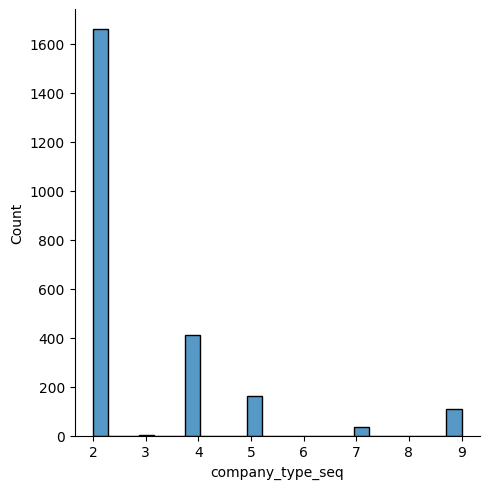

In [432]:
sns.displot(merged_recruitment, x = "company_type_seq")

In [433]:
merged_recruitment["company_type_seq"].value_counts()

2.0    1658
4.0     410
5.0     161
9.0     109
7.0      35
3.0       4
Name: company_type_seq, dtype: int64

In [434]:
# company_size 컬럼 생성
merged_recruitment['company_size'] = pd.cut(merged_recruitment['employee'],
    bins=[-1, 50, 300, 1000, float('inf')],
    labels=['소기업', '중소기업', '중견기업', '대기업'])

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 44204 (\N{HANGUL SYLLABLE GYEON}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44204 (\N{HANGUL SYLLABLE GYEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*a

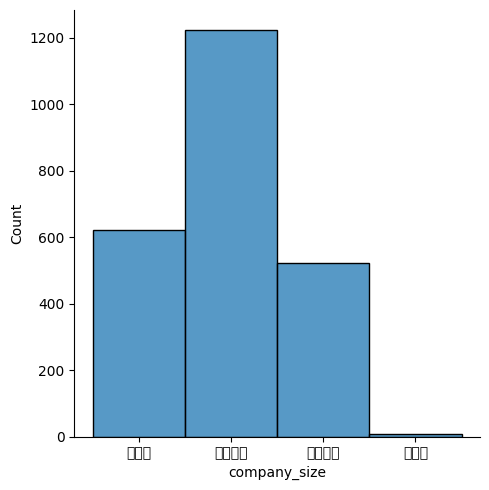

In [435]:
sns.displot(merged_recruitment, x="company_size")

In [436]:
merged_recruitment['company_size'].value_counts()

중소기업    1223
소기업      623
중견기업     523
대기업        8
Name: company_size, dtype: int64

In [437]:
merged_recruitment['company_size'] = merged_recruitment['company_size'].astype(str)

In [438]:
merged_recruitment['company_size'].fillna("미정기업", inplace = True)

In [439]:
merged_recruitment['company_type_seq'].value_counts()

2.0    1658
4.0     410
5.0     161
9.0     109
7.0      35
3.0       4
Name: company_type_seq, dtype: int64

In [440]:
merged_recruitment['company_type_seq'].fillna(0, inplace = True)

In [441]:
merged_recruitment['supply_kind'].value_counts()

402.0    1606
100.0     463
514.0     126
201.0     101
508.0      33
501.0      20
515.0       6
601.0       5
409.0       5
507.0       4
413.0       2
502.0       1
513.0       1
605.0       1
603.0       1
512.0       1
412.0       1
Name: supply_kind, dtype: int64

In [442]:
def supply_kind_range(type):
  if type == 402 :
    return 1
  elif type == 100 :
    return 2
  elif type == 514 :
    return 3
  elif type == 201 :
    return 4
  else:
    return 5

merged_recruitment['supply_kind'] = merged_recruitment['supply_kind'].apply(supply_kind_range)

In [443]:
def employee_cnt(cnt):
    if cnt >= 500:
        return 1
    elif cnt >= 100:
        return 2
    elif cnt >= 20:
        return 3
    elif cnt >= 1:
        return 4
    elif cnt == 0:
        return 5
    else:
        return 6
merged_recruitment['employee'] = merged_recruitment['employee'].apply(employee_cnt)

In [444]:
merged_recruitment['address_seq1'].fillna(3, inplace = True)

In [445]:

merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   recruitment_seq      6695 non-null   object 
 1   address_seq1         6695 non-null   float64
 2   check_box_keyword    6695 non-null   object 
 3   education            6695 non-null   int64  
 4   major_task           6695 non-null   int64  
 5   qualifications       6695 non-null   int64  
 6   company_type_seq     6695 non-null   float64
 7   supply_kind          6695 non-null   int64  
 8   employee             6695 non-null   int64  
 9   check_box_2101       6695 non-null   int64  
 10  check_box_2108       6695 non-null   int64  
 11  check_box_2201       6695 non-null   int64  
 12  check_box_2204       6695 non-null   int64  
 13  check_box_2205       6695 non-null   int64  
 14  check_box_2707       6695 non-null   int64  
 15  check_box_2810       6695 non-null   i

In [446]:
merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,company_type_seq,supply_kind,employee,check_box_2101,...,check_box_2104,check_box_2105,check_box_3008,check_box_3099,check_box_2302,check_box_2299,check_box_2102,check_box_keyword_1,recruit_code,company_size
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,5.0,4,1,1,...,0,0,0,0,0,0,0,2101,MD,중견기업
1,R00002,3.0,2507;2703;2707,3,2,1,2.0,4,2,0,...,0,0,0,0,0,0,0,2507,디자이너,중소기업
2,R00003,3.0,2101;2108;2201;2707,3,2,2,0.0,5,6,1,...,0,0,0,0,0,0,0,2101,MD,nan
3,R00004,3.0,2507;2707,3,2,1,2.0,1,1,0,...,0,0,0,0,0,0,0,2507,디자이너,중견기업
4,R00005,3.0,2507;2707,3,2,1,0.0,5,6,0,...,0,0,0,0,0,0,0,2507,디자이너,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,0.0,5,6,0,...,0,0,0,0,0,0,0,2501,기타,nan
6691,R06692,3.0,2201;2507,3,2,2,4.0,1,2,0,...,0,0,0,0,0,0,0,2201,영업 및 관리,중소기업
6692,R06693,5.0,2102;2707,4,2,1,0.0,5,6,0,...,0,0,0,0,0,0,1,2102,기타,nan
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,0.0,5,6,1,...,0,0,0,0,0,0,0,2101,MD,nan


In [447]:
merged_recruitment.columns

Index(['recruitment_seq', 'address_seq1', 'check_box_keyword', 'education',
       'major_task', 'qualifications', 'company_type_seq', 'supply_kind',
       'employee', 'check_box_2101', 'check_box_2108', 'check_box_2201',
       'check_box_2204', 'check_box_2205', 'check_box_2707', 'check_box_2810',
       'check_box_2507', 'check_box_2703', 'check_box_2109', 'check_box_2110',
       'check_box_2203', 'check_box_2501', 'check_box_2104', 'check_box_2105',
       'check_box_3008', 'check_box_3099', 'check_box_2302', 'check_box_2299',
       'check_box_2102', 'check_box_keyword_1', 'recruit_code',
       'company_size'],
      dtype='object')

In [448]:
merged_recruitment['company_size'] = merged_recruitment['company_size'].astype(str)

In [449]:
merged_recruitment['company_size'].unique()

array(['중견기업', '중소기업', 'nan', '소기업', '대기업'], dtype=object)

In [450]:
merged_recruitment['company_size'].replace('nan',"미정기업", inplace = True)

In [451]:
merged_recruitment['company_size'].unique()

array(['중견기업', '중소기업', '미정기업', '소기업', '대기업'], dtype=object)

In [452]:
merged_recruitment['recruit_code'].unique()

array(['MD', '디자이너', '영업 및 관리', 'VMD', '기타'], dtype=object)

In [453]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 32 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   recruitment_seq      6695 non-null   object 
 1   address_seq1         6695 non-null   float64
 2   check_box_keyword    6695 non-null   object 
 3   education            6695 non-null   int64  
 4   major_task           6695 non-null   int64  
 5   qualifications       6695 non-null   int64  
 6   company_type_seq     6695 non-null   float64
 7   supply_kind          6695 non-null   int64  
 8   employee             6695 non-null   int64  
 9   check_box_2101       6695 non-null   int64  
 10  check_box_2108       6695 non-null   int64  
 11  check_box_2201       6695 non-null   int64  
 12  check_box_2204       6695 non-null   int64  
 13  check_box_2205       6695 non-null   int64  
 14  check_box_2707       6695 non-null   int64  
 15  check_box_2810       6695 non-null   i

In [454]:
merged_recruitment['recruit_code'] = merged_recruitment['recruit_code'].astype("category")

In [455]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_recruitment['recruit_code'] = label_encoder.fit_transform(merged_recruitment['recruit_code'])
merged_recruitment['company_size'] = label_encoder.fit_transform(merged_recruitment['company_size'])



In [456]:
merged_recruitment.drop(columns = 'check_box_keyword_1',inplace = True)
merged_recruitment.drop(columns = 'check_box_keyword', inplace= True)

In [457]:
merged_recruitment.columns

Index(['recruitment_seq', 'address_seq1', 'education', 'major_task',
       'qualifications', 'company_type_seq', 'supply_kind', 'employee',
       'check_box_2101', 'check_box_2108', 'check_box_2201', 'check_box_2204',
       'check_box_2205', 'check_box_2707', 'check_box_2810', 'check_box_2507',
       'check_box_2703', 'check_box_2109', 'check_box_2110', 'check_box_2203',
       'check_box_2501', 'check_box_2104', 'check_box_2105', 'check_box_3008',
       'check_box_3099', 'check_box_2302', 'check_box_2299', 'check_box_2102',
       'recruit_code', 'company_size'],
      dtype='object')

In [458]:
for col in ['address_seq1', 'education', 'major_task',
       'qualifications', 'company_type_seq', 'supply_kind', 'employee',
       'check_box_2101', 'check_box_2108', 'check_box_2201', 'check_box_2204',
       'check_box_2205', 'check_box_2707', 'check_box_2810', 'check_box_2507',
       'check_box_2703', 'check_box_2109', 'check_box_2110', 'check_box_2203',
       'check_box_2501', 'check_box_2104', 'check_box_2105', 'check_box_3008',
       'check_box_3099', 'check_box_2302', 'check_box_2299', 'check_box_2102',
       'recruit_code', 'company_size']:
  merged_recruitment[col] = merged_recruitment[col].astype("category")

In [459]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   category
 2   education         6695 non-null   category
 3   major_task        6695 non-null   category
 4   qualifications    6695 non-null   category
 5   company_type_seq  6695 non-null   category
 6   supply_kind       6695 non-null   category
 7   employee          6695 non-null   category
 8   check_box_2101    6695 non-null   category
 9   check_box_2108    6695 non-null   category
 10  check_box_2201    6695 non-null   category
 11  check_box_2204    6695 non-null   category
 12  check_box_2205    6695 non-null   category
 13  check_box_2707    6695 non-null   category
 14  check_box_2810    6695 non-null   category
 15  check_box_2507    6695 non-null   category
 16  check_box_2703    6695 n

In [460]:
merged_recruitment_tmp = merged_recruitment[['recruitment_seq']]

In [461]:
_train_encoded = pd.DataFrame()

for col in ['address_seq1', 'education', 'major_task',
       'qualifications', 'company_type_seq', 'supply_kind', 'employee',
       'check_box_2101', 'check_box_2108', 'check_box_2201', 'check_box_2204',
       'check_box_2205', 'check_box_2707', 'check_box_2810', 'check_box_2507',
       'check_box_2703', 'check_box_2109', 'check_box_2110', 'check_box_2203',
       'check_box_2501', 'check_box_2104', 'check_box_2105', 'check_box_3008',
       'check_box_3099', 'check_box_2302', 'check_box_2299', 'check_box_2102',
       'recruit_code', 'company_size']: # 수정
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(merged_recruitment[col])
  _encoded = _encoder.transform(merged_recruitment[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

In [462]:
merged_recruitment_enc = pd.merge(merged_recruitment_tmp, _train_encoded, left_index=True, right_index=True, how='inner')

In [463]:
merged_recruitment_enc

,recruitment_seq,address_seq1_5.0,address_seq1_3.0,address_seq1_2.0,address_seq1_20.0,address_seq1_9.0,address_seq1_1.0,address_seq1_13.0,address_seq1_11.0,education_2.0,...,recruit_code_0.0,recruit_code_3.0,recruit_code_4.0,recruit_code_1.0,recruit_code_2.0,company_size_3.0,company_size_4.0,company_size_1.0,company_size_2.0,company_size_0.0
0,R00001,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,R00002,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,R00003,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,R00004,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,R00005,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6691,R06692,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6692,R06693,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6693,R06694,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [464]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   category
 2   education         6695 non-null   category
 3   major_task        6695 non-null   category
 4   qualifications    6695 non-null   category
 5   company_type_seq  6695 non-null   category
 6   supply_kind       6695 non-null   category
 7   employee          6695 non-null   category
 8   check_box_2101    6695 non-null   category
 9   check_box_2108    6695 non-null   category
 10  check_box_2201    6695 non-null   category
 11  check_box_2204    6695 non-null   category
 12  check_box_2205    6695 non-null   category
 13  check_box_2707    6695 non-null   category
 14  check_box_2810    6695 non-null   category
 15  check_box_2507    6695 non-null   category
 16  check_box_2703    6695 n

In [465]:
'''
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)
object_cols = list(merged_recruitment_object.columns)

for col in object_cols:
  merged_recruitment[col] = merged_recruitment[col].astype('category')

#형 변환 확인
merged_recruitment.info()
'''

"\n#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환\nmerged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)\nobject_cols = list(merged_recruitment_object.columns)\n\nfor col in object_cols:\n  merged_recruitment[col] = merged_recruitment[col].astype('category')\n\n#형 변환 확인\nmerged_recruitment.info()\n"

### merged_resume 생성

In [466]:
# resume 정렬 (resume_seq 기준)
resume = resume.sort_values(by='resume_seq')

In [467]:
# resume_certificate 정렬 (resume_seq 기준)
resume_certificate = resume_certificate.sort_values(by='resume_seq')
# certificate_contents에 결측값이 존재하는 행 제거
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
# 이력서번호(resume_seq)기준으로 groupby
# 이력서번호(resume_seq)의 해당하는 자격증들을 세미콜론(;)으로 join해서 적용(apply)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()

In [468]:
# resume_education 정렬 (resume_seq 기준)
resume_education = resume_education.sort_values(by='resume_seq')

In [469]:
# resume_language 정렬 (resume_seq 기준)
resume_language = resume_language.sort_values(by='resume_seq')

#### language

In [470]:
def convert_to_grade(row):
    lang = row['language']
    score = row['score']
    min_score, max_score = 0, 1000  # 범위를 직접 설정
    if lang in [2, 3, 4, 9]:
        if min_score <= score <= max_score:
            if 800 <= score <= 999:
                return 1
            elif 500 <= score < 700:
                return 2
            else:
                return 3
    else:                          # 8인 경우만 score 650
        return 2
resume_language['score'] = resume_language.apply(convert_to_grade, axis=1)
resume_language = resume_language.drop(columns = 'exam_name')
resume_language.sort_values(by='resume_seq', inplace = True)
resume_language = resume_language.drop_duplicates(subset='resume_seq')

In [471]:
resume_language.drop(columns='language', inplace = True)

In [472]:
resume_language

,resume_seq,score
45,U00004,2
701,U00005,1
205,U00039,1
645,U00054,1
769,U00067,3
...,...,...
424,U08443,2
728,U08461,2
278,U08465,3
212,U08472,2


#### education

In [473]:
def score_range(score):
  if score >= 5:
        if score >= 90:
            return 1
        elif score >= 80:
            return 2
        elif score >=70:
            return 3
        else:
            return 4
  else:
        if score >= 4.0:
            return 1
        elif score >= 3.5:
            return 2
        elif score >= 3.0:
            return 3
        else:
            return 4

resume_education['univ_score'] = resume_education['univ_score'].apply(score_range)

In [474]:
resume_education = resume_education[['resume_seq','univ_score']]

#### resume

In [475]:
resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code
1690,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,NaN,0,NaN
3979,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,NaN,73,기타 공공;개인서비스
5648,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,NaN,113,섬유;봉제;가방;의류
1367,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,NaN,27,섬유;봉제;가방;의류
5242,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,NaN,60,섬유;봉제;가방;의류
2227,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,NaN,59,디자인;CAD;설계
2657,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,NaN,0,NaN
6619,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,NaN,8,섬유;봉제;가방;의류


In [476]:
job_code_mapping = {
    '재료·화학·섬유·의복': 1,
    '디자인': 2,
    '경영·기획·회계·사무': 3,
    '영업·판매·TM': 4,
    '건설·기계·전기·전자': 5,
    '전문·교육·자격':5,
    'IT·게임'                 :5,
    '기타 직종'                :5,
    '문화·예술·신문·방송'   :5
}

resume['job_code_seq1'] = resume['job_code_seq1'].map(job_code_mapping)

In [477]:
resume['text_keyword'] = resume['text_keyword'].astype(str).apply(lambda x : x.split(';')[0])

In [478]:
def keyword_range(keyword):
  if '기획' in keyword:
    return 1
  elif '디자' in keyword or '패션' in keyword or '의류' in keyword:
    return 2
  elif '매장영업관리' in keyword:
    return 3
  elif '영업' in keyword or '마케팅' in keyword:
    return 4
  elif '관리' in keyword:
    return 5
  else :
    return 6


resume['text_keyword'] = resume['text_keyword'].apply(keyword_range)

In [479]:
resume['text_keyword'].value_counts()

2    2829
6    2224
1    1428
4    1190
3     428
5     383
Name: text_keyword, dtype: int64

In [480]:
careeer_job_code_mapping = {
    '섬유;봉제;가방;의류' : 1,
    '도소매;유통;무역'    : 2,
    '디자인;CAD;설계'     : 3,
}

resume['career_job_code'] = resume['career_job_code'].map(careeer_job_code_mapping)

def else_career(career_code):
  if career_code != 1 or career_code != 2 or career_code != 3:
    return 4

resume['career_job_code'] = resume['career_job_code'].apply(else_career)

In [481]:
def career_range(career):
  if career >= 60: # 5년이상 1
    return 1
  elif career >= 12: # 1년이상 2
    return 2
  elif career >= 1: # 경력 1개월 이상 3
    return 3
  else :
    return 4

resume['career_month'] = resume['career_month'].apply(career_range)

In [482]:
resume = resume[['resume_seq','degree','text_keyword','job_code_seq1','career_month','career_job_code']]

#### certificate

In [483]:
resume_certificate = pd.DataFrame(resume_certificate, dtype=str)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(lambda x: ';'.join(x)).reset_index()
resume_certificate['cnt'] = resume_certificate['certificate_contents'].apply(lambda x: len(x.split(';')))

In [484]:
resume_certificate.drop(columns = 'certificate_contents', inplace = True)

In [485]:
# merged_resume = resume, resume_certificate, resume_education, resume_language
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

,resume_seq,degree,text_keyword,job_code_seq1,career_month,career_job_code,cnt,univ_score,score
0,U00001,4,2,1,4,4,NaN,4,NaN
1,U00002,4,2,1,1,4,1.0,1,NaN
2,U00003,4,2,1,1,4,3.0,1,NaN
3,U00004,4,1,1,2,4,3.0,3,2.0
4,U00005,4,6,1,4,4,NaN,4,1.0
...,...,...,...,...,...,...,...,...,...
8477,U08478,4,1,1,1,4,NaN,4,NaN
8478,U08479,3,2,1,2,4,1.0,4,NaN
8479,U08480,4,6,2,4,4,4.0,2,NaN
8480,U08481,4,1,1,3,4,1.0,4,NaN


In [486]:
merged_resume['cnt'].fillna(0, inplace = True)
merged_resume['score'].fillna(0, inplace = True)

In [487]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resume_seq       8482 non-null   object 
 1   degree           8482 non-null   int64  
 2   text_keyword     8482 non-null   int64  
 3   job_code_seq1    8482 non-null   int64  
 4   career_month     8482 non-null   int64  
 5   career_job_code  8482 non-null   int64  
 6   cnt              8482 non-null   float64
 7   univ_score       8482 non-null   int64  
 8   score            8482 non-null   float64
dtypes: float64(2), int64(6), object(1)
memory usage: 662.7+ KB


### merged_resume 탐색 & drop

In [488]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resume_seq       8482 non-null   object 
 1   degree           8482 non-null   int64  
 2   text_keyword     8482 non-null   int64  
 3   job_code_seq1    8482 non-null   int64  
 4   career_month     8482 non-null   int64  
 5   career_job_code  8482 non-null   int64  
 6   cnt              8482 non-null   float64
 7   univ_score       8482 non-null   int64  
 8   score            8482 non-null   float64
dtypes: float64(2), int64(6), object(1)
memory usage: 662.7+ KB


In [489]:
merged_resume.describe()

,degree,text_keyword,job_code_seq1,career_month,career_job_code,cnt,univ_score,score
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.0,8482.000000,8482.000000,8482.000000
mean,3.938222,3.346970,1.239566,1.843669,4.0,1.529238,2.429498,0.196180
std,0.440764,1.888842,0.651810,1.008904,0.0,1.552267,0.888975,0.657425
min,2.000000,1.000000,1.000000,1.000000,4.0,0.000000,1.000000,0.000000
25%,4.000000,2.000000,1.000000,1.000000,4.0,0.000000,2.000000,0.000000
50%,4.000000,2.000000,1.000000,2.000000,4.0,1.000000,2.000000,0.000000
75%,4.000000,6.000000,1.000000,2.000000,4.0,2.000000,3.000000,0.000000
max,6.000000,6.000000,5.000000,4.000000,4.0,10.000000,4.000000,3.000000


In [490]:
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq         0.0
degree             0.0
text_keyword       0.0
job_code_seq1      0.0
career_month       0.0
career_job_code    0.0
cnt                0.0
univ_score         0.0
score              0.0
dtype: float64

In [491]:
merged_resume["text_keyword"]

0       2
1       2
2       2
3       1
4       6
       ..
8477    1
8478    2
8479    6
8480    1
8481    1
Name: text_keyword, Length: 8482, dtype: int64

In [492]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resume_seq       8482 non-null   object 
 1   degree           8482 non-null   int64  
 2   text_keyword     8482 non-null   int64  
 3   job_code_seq1    8482 non-null   int64  
 4   career_month     8482 non-null   int64  
 5   career_job_code  8482 non-null   int64  
 6   cnt              8482 non-null   float64
 7   univ_score       8482 non-null   int64  
 8   score            8482 non-null   float64
dtypes: float64(2), int64(6), object(1)
memory usage: 662.7+ KB


In [493]:
merged_resume

,resume_seq,degree,text_keyword,job_code_seq1,career_month,career_job_code,cnt,univ_score,score
0,U00001,4,2,1,4,4,0.0,4,0.0
1,U00002,4,2,1,1,4,1.0,1,0.0
2,U00003,4,2,1,1,4,3.0,1,0.0
3,U00004,4,1,1,2,4,3.0,3,2.0
4,U00005,4,6,1,4,4,0.0,4,1.0
...,...,...,...,...,...,...,...,...,...
8477,U08478,4,1,1,1,4,0.0,4,0.0
8478,U08479,3,2,1,2,4,1.0,4,0.0
8479,U08480,4,6,2,4,4,4.0,2,0.0
8480,U08481,4,1,1,3,4,1.0,4,0.0


In [494]:
merged_resume.columns

Index(['resume_seq', 'degree', 'text_keyword', 'job_code_seq1', 'career_month',
       'career_job_code', 'cnt', 'univ_score', 'score'],
      dtype='object')

In [495]:
merged_resume_c = merged_resume.copy()

In [496]:
merged_resume_tmp = merged_resume_c[['resume_seq']]

In [497]:
merged_resume_c['degree'] = merged_resume_c['degree'].astype("category")
merged_resume_c['text_keyword'] = merged_resume_c['text_keyword'].astype("category")
merged_resume_c['job_code_seq1'] = merged_resume_c['job_code_seq1'].astype("category")
merged_resume_c['career_month'] = merged_resume_c['career_month'].astype("category")
merged_resume_c['career_job_code'] = merged_resume_c['career_job_code'].astype("category")
merged_resume_c['cnt'] = merged_resume_c['cnt'].astype("category")
merged_resume_c['univ_score'] = merged_resume_c['univ_score'].astype("category")
merged_resume_c['score'] = merged_resume_c['score'].astype("category")


In [498]:
_train_encoded = pd.DataFrame()

for col in ['degree', 'text_keyword', 'job_code_seq1', 'career_month',
       'career_job_code', 'cnt', 'univ_score', 'score']: # 수정
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(merged_resume_c[col])
  _encoded = _encoder.transform(merged_resume_c[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

In [499]:
merged_resume_enc = pd.merge(merged_resume_tmp, _train_encoded, left_index=True, right_index=True, how='inner')

In [500]:
merged_resume_enc

,resume_seq,degree_4.0,degree_3.0,degree_2.0,degree_5.0,degree_6.0,text_keyword_2.0,text_keyword_1.0,text_keyword_6.0,text_keyword_3.0,...,cnt_9.0,cnt_10.0,univ_score_4.0,univ_score_1.0,univ_score_3.0,univ_score_2.0,score_0.0,score_2.0,score_1.0,score_3.0
0,U00001,1,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,U00002,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,U00003,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,U00004,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,U00005,1,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
8478,U08479,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
8479,U08480,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0
8480,U08481,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0


# 유사도 샘플링  데이터

# apply_matrix

In [532]:
from sklearn.metrics.pairwise import cosine_similarity

In [529]:
pred = apply_train_df.copy()

In [530]:
# 사용자-아이템 행렬 생성: 구직자가 해당 채용 공고에 지원했으면 1, 아니면 0으로 설정
#train_user_item_matrix = train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)

#val_user_item_matrix = val.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)

pred_user_item_matrix  = pred.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)

In [533]:
#train_user_similarity  = cosine_similarity(train_user_item_matrix) # train 이력서 간의 유사성 계산

#val_user_similarity  = cosine_similarity(val_user_item_matrix) # val 이력서 간의 유사성 계산

pred_user_similarity  = cosine_similarity(pred_user_item_matrix) # apply 이력서 간의 유사성 계산

In [534]:
#train_item_similarity = cosine_similarity(train_user_item_matrix.T) # train 공고 간의 유사성 계산

#val_item_similarity = cosine_similarity(val_user_item_matrix.T) # val 공고 간의 유사성 계산

pred_item_similarity = cosine_similarity(pred_user_item_matrix.T) # apply 공고 간의 유사성 계산

In [535]:
#train_user_predicted_scores = train_user_similarity.dot(train_user_item_matrix)

#train_item_predicted_scores = train_user_item_matrix.dot(train_item_similarity)

#val_user_predicted_scores = val_user_similarity.dot(val_user_item_matrix)

#val_item_predicted_scores = val_user_item_matrix.dot(val_item_similarity)

pred_user_predicted_scores = pred_user_similarity.dot(pred_user_item_matrix)
# 각 사용자의 각 공고에 대한 예측 점수가 저장. 각 셀은 해당 사용자가 해당 공고를 지원할 가능성

pred_item_predicted_scores = pred_user_item_matrix.dot(pred_item_similarity)
# 각 공고에 대한 예측 점수가 저장. 각 셀은 해당 공고가 어떤 사용자에게 얼마나 적합한지

# pred 결과 도출

In [536]:
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD, NMF, SparsePCA
from sklearn.metrics.pairwise import cosine_similarity

In [537]:
alpha = 0.98
top_recommendations = []

for idx, user in tqdm(enumerate(pred_user_item_matrix.index)):
    applied_jobs = set(pred_user_item_matrix.loc[user][pred_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (pred_item_predicted_scores.loc[user].values * alpha + pred_user_predicted_scores[idx]).argsort()[::-1]

    # 이미 지원하지 않은 공고를 선택
    recommended_jobs = [job for job in pred_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:100]


    for job in recommended_jobs:
        top_recommendations.append([user, job])

0it [00:00, ?it/s]

In [538]:
# sample_submission.csv 형태로 DataFrame 생성
pred_recommendations = pd.DataFrame(top_recommendations, columns=['resume_seq', 'recruitment_seq'])


In [539]:
pred_recommendations

,resume_seq,recruitment_seq
0,U00001,R01528
1,U00001,R03811
2,U00001,R06276
3,U00001,R03037
4,U00001,R04769
...,...,...
848195,U08482,R00433
848196,U08482,R04719
848197,U08482,R02808
848198,U08482,R05989


# Negative Sampling

In [501]:
#학습, 검증 분리
apply_train_list_tr, apply_train_list_te = [], []
apply_train_groupby = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        apply_train_list_tr.append([uid,iid])
    apply_train_list_te.append([uid, iids[-1]])

In [502]:
apply_train_tr = pd.DataFrame(apply_train_list_tr, columns=['resume_seq', 'recruitment_seq'])
apply_train_te = pd.DataFrame(apply_train_list_te, columns=['resume_seq', 'recruitment_seq'])

In [503]:
#학습, 검증 모두 결과값은 같음
resume_pool = set(apply_train["resume_seq"].unique())
recruitment_pool = set(apply_train['recruitment_seq'].unique())

len(resume_pool), len(recruitment_pool)

(8482, 6695)

In [504]:
df_add_negative_tr = apply_train_tr.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})
df_add_negative_te = apply_train_te.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})

df_add_negative_tr

,resume_seq,interacted_iid
0,U00001,"{R06065, R05210, R05288}"
1,U00002,"{R06019, R01960, R02346, R02946, R04588, R0547..."
2,U00003,"{R04918, R01460}"
3,U00004,"{R01068, R04709, R03925, R01825, R05367, R0289..."
4,U00005,"{R03914, R00832}"
...,...,...
8477,U08478,{R02170}
8478,U08479,"{R02988, R01470, R04036, R04196, R03837}"
8479,U08480,{R00803}
8480,U08481,"{R05500, R00225}"


In [505]:
# 지원하지 않은 공고
df_add_negative_tr['negative_iid'] = df_add_negative_tr['interacted_iid'].map(lambda x: recruitment_pool - x)
df_add_negative_te['negative_iid'] = df_add_negative_te['interacted_iid'].map(lambda x: recruitment_pool - x)

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid
0,U00001,"{R06065, R05210, R05288}","{R02945, R06446, R04861, R03027, R02484, R0286..."
1,U00002,"{R06019, R01960, R02346, R02946, R04588, R0547...","{R02945, R06446, R04861, R03027, R02484, R0286..."
2,U00003,"{R04918, R01460}","{R02945, R06446, R04861, R03027, R02484, R0286..."
3,U00004,"{R01068, R04709, R03925, R01825, R05367, R0289...","{R02945, R06446, R04861, R03027, R02484, R0286..."
4,U00005,"{R03914, R00832}","{R02945, R06446, R04861, R03027, R02484, R0286..."
...,...,...,...
8477,U08478,{R02170},"{R02945, R06446, R04861, R03027, R02484, R0286..."
8478,U08479,"{R02988, R01470, R04036, R04196, R03837}","{R02945, R06446, R04861, R03027, R02484, R0286..."
8479,U08480,{R00803},"{R02945, R06446, R04861, R03027, R02484, R0286..."
8480,U08481,"{R05500, R00225}","{R02945, R06446, R04861, R03027, R02484, R0286..."


In [506]:
# 지원한 공고의 수
df_add_negative_tr['interacted_iid_cnt'] = df_add_negative_tr['interacted_iid'].map(lambda x: len(x))
df_add_negative_te['interacted_iid_cnt'] = df_add_negative_te['interacted_iid'].map(lambda x: len(x))

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid,interacted_iid_cnt
0,U00001,"{R06065, R05210, R05288}","{R02945, R06446, R04861, R03027, R02484, R0286...",3
1,U00002,"{R06019, R01960, R02346, R02946, R04588, R0547...","{R02945, R06446, R04861, R03027, R02484, R0286...",7
2,U00003,"{R04918, R01460}","{R02945, R06446, R04861, R03027, R02484, R0286...",2
3,U00004,"{R01068, R04709, R03925, R01825, R05367, R0289...","{R02945, R06446, R04861, R03027, R02484, R0286...",16
4,U00005,"{R03914, R00832}","{R02945, R06446, R04861, R03027, R02484, R0286...",2
...,...,...,...,...
8477,U08478,{R02170},"{R02945, R06446, R04861, R03027, R02484, R0286...",1
8478,U08479,"{R02988, R01470, R04036, R04196, R03837}","{R02945, R06446, R04861, R03027, R02484, R0286...",5
8479,U08480,{R00803},"{R02945, R06446, R04861, R03027, R02484, R0286...",1
8480,U08481,"{R05500, R00225}","{R02945, R06446, R04861, R03027, R02484, R0286...",2


In [507]:
# 지원한 공고 횟수만큼 지원하지 않은 회사 추출..
df_add_negative_tr['negative_sampling'] = df_add_negative_tr.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)
df_add_negative_te['negative_sampling'] = df_add_negative_te.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)

df_add_negative_tr[['resume_seq','interacted_iid', 'negative_sampling']].head()

,resume_seq,interacted_iid,negative_sampling
0,U00001,"{R06065, R05210, R05288}","[R01368, R05747, R03931]"
1,U00002,"{R06019, R01960, R02346, R02946, R04588, R0547...","[R02156, R05820, R01329, R01278, R00700, R0175..."
2,U00003,"{R04918, R01460}","[R01597, R05250]"
3,U00004,"{R01068, R04709, R03925, R01825, R05367, R0289...","[R04536, R03275, R05574, R00194, R04117, R0402..."
4,U00005,"{R03914, R00832}","[R04099, R00863]"


In [508]:
# 리스트인 interacted_iid 컬럼을 각각 row로 변경한다.
df_interacted_tr = df_add_negative_tr[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )
df_interacted_te = df_add_negative_te[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )

# 지원한 회사이므로 target 컬럼의 모든 값은 1
df_interacted_tr['target'] = 1
df_interacted_te['target'] = 1

# 인덱스 재정렬
df_interacted_tr.reset_index(drop=True, inplace=True)
df_interacted_te.reset_index(drop=True, inplace=True)

print(df_interacted_tr.shape, df_interacted_te.shape)
df_interacted_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R06065,1
1,U00001,R05210,1
2,U00001,R05288,1
3,U00002,R06019,1
4,U00002,R01960,1


In [509]:
# 리스트인 negative_sampling 컬럼을 각각 row로 변경한다.
df_negatived_tr = df_add_negative_tr[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
df_negatived_te = df_add_negative_te[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
# 지원하지 않은 공고이므로 target은 0
df_negatived_tr['target'] = 0
df_negatived_te['target'] = 0

# 인덱스 재정렬
df_negatived_tr.reset_index(drop=True, inplace=True)
df_negatived_te.reset_index(drop=True, inplace=True)

print(df_negatived_tr.shape, df_negatived_te.shape)
df_negatived_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R01368,0
1,U00001,R05747,0
2,U00001,R03931,0
3,U00002,R02156,0
4,U00002,R05820,0


In [510]:
# 지원한 공고 df, 지원하지 않은 공고 df를 합친다.
# axis = 0 : row로 합친다.
df_concat_tr = pd.concat([df_interacted_tr, df_negatived_tr], axis=0)
df_concat_te = pd.concat([df_interacted_te, df_negatived_te], axis=0)

print(df_concat_tr.shape, df_concat_te.shape)
df_concat_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U00001,R06065,1
1,U00001,R05210,1
2,U00001,R05288,1
3,U00002,R06019,1
4,U00002,R01960,1


In [511]:
# df_concat.sample(frac=1) : df전체를 무작위 샘플로 생성
# 인덱스 재정렬
df_shuffle_tr = df_concat_tr.sample(frac=1).reset_index(drop=True)
df_shuffle_te = df_concat_te.sample(frac=1).reset_index(drop=True)

print(df_shuffle_tr.shape, df_shuffle_te.shape)
df_shuffle_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U03412,R03237,1
1,U00974,R02135,1
2,U04802,R01250,0
3,U07016,R05714,1
4,U03627,R00921,0


In [512]:
df_shuffle_tr['target'].value_counts()

1    49464
0    49464
Name: target, dtype: int64

In [513]:
df_shuffle_te['target'].value_counts()

0    8482
1    8482
Name: target, dtype: int64

# 학습용 데이터 생성

In [514]:
_df_train = pd.merge(df_shuffle_tr, merged_recruitment_enc, on='recruitment_seq', how='left')
df_train = pd.merge(_df_train, merged_resume_enc, on='resume_seq', how='left')
df_train

,resume_seq,recruitment_seq,target,address_seq1_5.0,address_seq1_3.0,address_seq1_2.0,address_seq1_20.0,address_seq1_9.0,address_seq1_1.0,address_seq1_13.0,...,cnt_9.0,cnt_10.0,univ_score_4.0,univ_score_1.0,univ_score_3.0,univ_score_2.0,score_0.0,score_2.0,score_1.0,score_3.0
0,U03412,R03237,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,U00974,R02135,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,U04802,R01250,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,U07016,R05714,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,U03627,R00921,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98923,U07088,R01538,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
98924,U02338,R00309,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
98925,U00778,R03096,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
98926,U07834,R01395,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [515]:
_df_test= pd.merge(df_shuffle_te, merged_recruitment_enc, on='recruitment_seq', how='left')
df_test = pd.merge(_df_test, merged_resume_enc, on='resume_seq', how='left')
df_test.head()

,resume_seq,recruitment_seq,target,address_seq1_5.0,address_seq1_3.0,address_seq1_2.0,address_seq1_20.0,address_seq1_9.0,address_seq1_1.0,address_seq1_13.0,...,cnt_9.0,cnt_10.0,univ_score_4.0,univ_score_1.0,univ_score_3.0,univ_score_2.0,score_0.0,score_2.0,score_1.0,score_3.0
0,U00513,R02968,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1,U06684,R01097,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,U07840,R04240,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
3,U03953,R01608,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,U01467,R04817,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0


In [516]:
#필요없는 id 컬럼('recruitment_seq', 'resume_seq' 제거)
drop_col = ['recruitment_seq', 'resume_seq']
df_train.drop(drop_col, axis = 1, inplace=True)
df_test.drop(drop_col, axis = 1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 0 to 98927
Columns: 131 entries, target to score_3.0
dtypes: int64(131)
memory usage: 99.6 MB


In [517]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [518]:
X_tr = df_train.drop('target', axis=1)
y_tr = df_train['target']

X_te = df_test.drop('target', axis=1)
y_te = df_test['target']

# modelV0 (XGBoost, base model)

## 학습

In [520]:
from xgboost import XGBClassifier, plot_importance

hp = {
    "random_state" : 42,
    "max_depth" : 5,  #max_depth 를 5로 변경
    "n_estimators" : 2000, # 120 > 150 으로
    "learning_rate" : 0.2,
    "min_child_weight": 2,
}

model_V0 = XGBClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {model_V0.score(X_tr, y_tr)} / 테스트용 평가지표: {model_V0.score(X_te, y_te)}')

훈련용 평가지표: 0.7746441856703865 / 테스트용 평가지표: 0.7008370667295449


## 학습평가

In [521]:
from sklearn.metrics import roc_curve, auc

In [522]:
y_tr.shape # 실제값
pred_tr = model_V0.predict(X_tr) # 예측값
pred_proba_tr = model_V0.predict_proba(X_tr)[:,1] # 예측확률

In [523]:
fpr, tpr, thresholds = roc_curve(y_tr, pred_proba_tr)
auc_tr = auc(fpr, tpr)
print(f'auc: {auc_tr}')

auc: 0.8567862004380964


In [524]:
y_te.shape # 실제값
pred_te = model_V0.predict(X_te) # 예측값
pred_proba_te = model_V0.predict_proba(X_te)[:,1] # 예측확률

In [525]:
# roc_curve(실제값, 예측확률값)
fpr, tpr, thresholds = roc_curve(y_te, pred_proba_te)
auc_te = auc(fpr, tpr)
print(f'auc: {auc_te}')

auc: 0.7632030221035923


In [526]:
print(f'train auc: {auc_tr} / test auc: {auc_te}')

train auc: 0.8567862004380964 / test auc: 0.7632030221035923


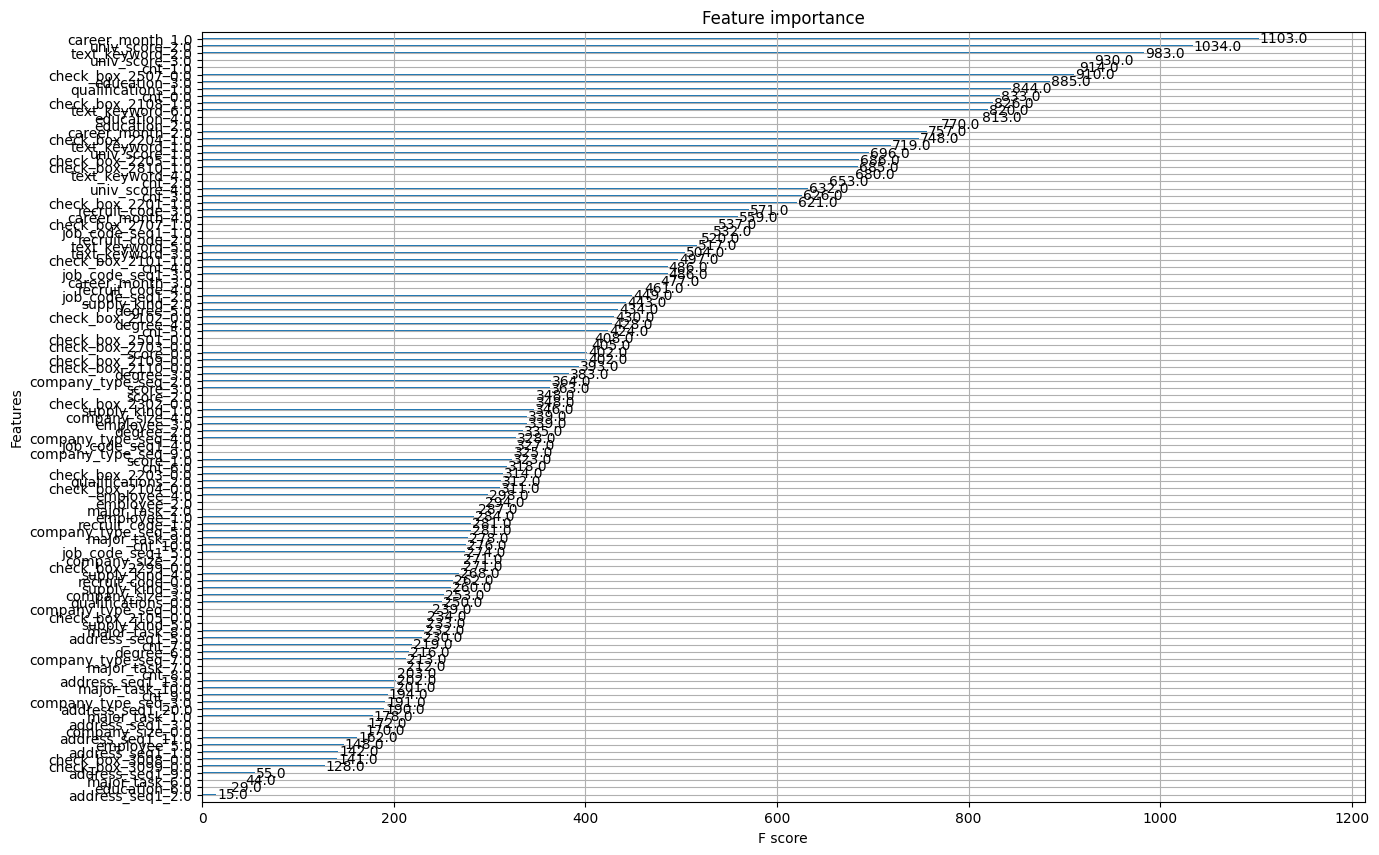

In [527]:
fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(model_V0,ax=ax)
plt.show()

In [528]:
from sklearn.metrics import confusion_matrix

In [540]:
# confusion_matrix(실제값, 예측값)
# normalize="true" -> 확률값으로 변경!!
conf_mx = confusion_matrix(y_te, pred_te, normalize="true")
conf_mx

array([[0.67095025, 0.32904975],
       [0.26927611, 0.73072389]])

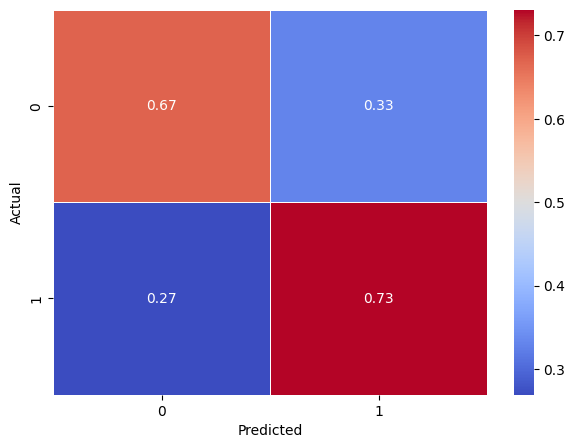

In [541]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# annot=True -> 수치데이터 표시
# cmap -> 히트맵 컬러정의
# linewidth -> 선 두께
sns.heatmap(conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 예측

In [ ]:
aaa

In [550]:
pred_recommendations = pred_recommendations.astype("category")

In [ ]:
pred_recommendations

In [543]:
best_model = model_V0

In [ ]:
for resume in tqdm(['U00001', 'U00002','U00003', 'U00004', 'U00005']):
  pred_recru = pred_recommendations[pred_recommendations['resume_seq'] == resume ]


pred_recru

In [553]:
for resume in tqdm(['U00001']):
  pred_recru = pred_recommendations[pred_recommendations['resume_seq'] == resume ]


pred_recru


  0%|          | 0/1 [00:00<?, ?it/s]

,resume_seq,recruitment_seq
0,U00001,R01528
1,U00001,R03811
2,U00001,R06276
3,U00001,R03037
4,U00001,R04769
...,...,...
95,U00001,R06059
96,U00001,R01722
97,U00001,R02710
98,U00001,R02457


In [546]:
all_recommendations = []

for resume in tqdm(resume_pool):
#for resume in tqdm(['U00001', 'U00002','U00003', 'U00004', 'U00005']):
    # 2. 임시 데이터프레임 생성
    _df_temp = pd.DataFrame({'resume_seq': [resume] * len(recruitment)})

    # 3. 전체 공고 seq를 붙임
    _df_temp['recruitment_seq'] = list(recruitment_pool)
    _df_temp.head()

    # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
    _df_train = pd.merge(_df_temp, merged_recruitment, on='recruitment_seq', how='left')
    _df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
    _df_train_drop_col = ['recruitment_seq', 'resume_seq']
    _df_train.drop(_df_train_drop_col, axis = 1, inplace=True)

    # 5. 예측 확률 계산
    pred_proba = best_model.predict_proba(_df_train)[:,1]

    # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
    _df_temp['prediction'] = pred_proba
    _df_temp = _df_temp.sort_values(by='prediction', ascending=False)

    # 7. 현재 구직자의 이미 지원한 공고 가져오기
    already_applied_jobs = apply_train[apply_train['resume_seq'] == resume]['recruitment_seq'].values

    # 8. 임시 데이터프레임에서 이미 지원한 공고를 제거
    _df_temp = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)]

    # 상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
    top_recommendations = _df_temp.head(5)

    # 결과 출력 또는 활용
    all_recommendations.append(top_recommendations)

final_recommendations = pd.concat(all_recommendations, ignore_index=True)
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]
final_recommendations = final_recommendations.sort_values(by='resume_seq')
final_recommendations


  0%|          | 0/5 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
submission_df[:20]

# Result 저장 (Submission)

In [ ]:
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]

In [ ]:
recall5(apply_train, final_recommendations)

In [ ]:
now = datetime.now() + timedelta(hours=9)
formatted_time = now.strftime("%Y%m%d_%H%M")

In [ ]:
final_recommendations.to_csv(args.default_path+ '/result/submission_'+formatted_time+'.csv', index=False)

유사도로 필터링된 이력서별 100개 공고번호 데이터

네거티브샘플링과 기펴로 학습이 된 모델

